In [1]:
import pandas as pd
import matplotlib.pyplot as plt

#spark imports
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

from pyspark.sql import Row, SparkSession
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator 

spark = SparkSession.builder.appName('Recommendation_system').getOrCreate()

#For very small jupyter notebook blocks, I did not make a specific function
#Because it would be overrated

In [2]:
def import_all_data(file_loc):
    file_location = file_loc
    file_type = "csv"
    
    # CSV options
    infer_schema = "True"
    first_row_is_header = "True"
    delimiter = ","
    
    # The applied options are for CSV files. For other file types, these will be ignored.
    dataframe = spark.read.format(file_type) \
      .option("inferSchema", infer_schema) \
      .option("header", first_row_is_header) \
      .option("sto_readep", delimiter) \
      .load(file_location)
    return dataframe

In [3]:
books_file_loc = "dataset\\cleaned_data_books_version_3.csv"
books = import_all_data(books_file_loc)

In [4]:
ratings_file_loc = "dataset\\ratings.csv"
ratings = import_all_data(ratings_file_loc)

In [5]:
to_read_file_loc = "dataset\\to_read.csv"
to_read = import_all_data(to_read_file_loc)

In [6]:
def sparsity_calc():
    # Count the total number of ratings in the dataset
    numerator = ratings.select("rating").count()

    # Count the number of distinct Id's
    num_users = ratings.select("user_id").distinct().count()
    num_items = ratings.select("book_id").distinct().count()

    # Set the denominator equal to the number of users multiplied by the number of items
    denominator = num_users * num_items

    # Divide the numerator by the denominator
    sparsity = (1.0 - (numerator * 1.0)/ denominator) * 100
    print("The ratings dataframe is ", "%.2f" % sparsity + "% empty.")

In [7]:
sparsity_calc()

The ratings dataframe is  99.82% empty.


In [8]:
#now, we split the data into training and test sets to use for the ALS algorithm
(training,test)=ratings.randomSplit([0.8, 0.2])

#here, a default ALS model is called upon for hyperparameter tuning
#and for RMSE calculation within the hyperparameter tuning function
als=ALS(userCol="user_id",itemCol="book_id", ratingCol="rating",coldStartStrategy="drop",nonnegative=True, implicitPrefs = False)
default_model=als.fit(training)

In [9]:
def tune_ALS(training, validation_data, maxIter, regParams, ranks, als_dt):
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in regParams:
            # get ALS model
            als = als_dt.setMaxIter(maxIter).setRank(rank).setRegParam(reg)
            # train ALS model
            model = als.fit(training)
            # evaluate the model by computing the RMSE on the validation data
            predictions = model.transform(test)
            evaluator = RegressionEvaluator(metricName="rmse",
                                            labelCol="rating",
                                            predictionCol="prediction")
            rmse = evaluator.evaluate(predictions)
            print('{} latent factors and regularization = {}: '
                  'validation RMSE is {}'.format(rank, reg, rmse))
            if rmse < min_error:
                min_error = rmse
                best_rank = rank
                best_regularization = reg
                best_model = model
    print('\nThe best model has {} latent factors and '
          'regularization = {}'.format(best_rank, best_regularization))
    return best_model

In [ ]:
tune_ALS(training, test, 10, [.01, .05, .1, .15, .2, .25, .5, 1], [5, 10, 20, 50, 70, 75, 100], als)

In [ ]:
tune_ALS(training, test, 20, [.05, .1, .15, .2, .25], [10, 50, 70, 100], als)

In [10]:
def extracting_info_from_model(insert_model):
    predictions = insert_model.transform(test)
    predictions.createOrReplaceTempView("predictions")
    print("Predictions")
    print(predictions.show())
    print("----------------------------------")
    #generate n recommendations for all users
    ALS_recommendations = insert_model.recommendForAllUsers(numItems = 10) # n - 10
    print("ALS recommendations")
    print(ALS_recommendations.show())
    print("----------------------------------")
    ALS_recommendations.toPandas()

    #temporary table
    ALS_recommendations.registerTempTable("ALS_recs_temp")

    clean_recs = spark.sql("""SELECT user_id,
                                movieIds_and_ratings.book_id AS book_id,
                                movieIds_and_ratings.rating AS prediction
                            FROM ALS_recs_temp
                            LATERAL VIEW explode(recommendations) exploded_table
                                AS movieIds_and_ratings""")
    print("Clean recommendations")
    print(clean_recs.show())
    print("----------------------------------")
    #recommendations for unread books
    new_books = (clean_recs.join(ratings, ["user_id", "book_id"], "left")
        .filter(ratings.rating.isNull()))
    print("Recommendations for unread books")
    print(new_books.show())
    print("----------------------------------")
    #create more temporary Tables
    new_books.createOrReplaceTempView("new_books")
    to_read.createOrReplaceTempView("to_read")

    recommendations = new_books.join(to_read,
                                  on = ["user_id", "book_id"], 
                                  how = "inner")
    print("Recommendations for unread books on the user's to_read page")
    print(recommendations.show())
    print("----------------------------------")

    # Create Temporary Tables
    recommendations.createOrReplaceTempView("recommendations")
    plt.figure(figsize=(12,6))
    plt.suptitle('Distribution of predicted ratings for the to_do lists', fontsize = 18)
    rec = recommendations.toPandas()
    rec['prediction'].hist()
    display()

Predictions
+-------+-------+------+----------+
|book_id|user_id|rating|prediction|
+-------+-------+------+----------+
|    148|   3087|     3| 3.3774285|
|    148|  38475|     4| 3.5598464|
|    148|  10140|     3| 2.8274121|
|    148|  27834|     3| 3.8022585|
|    148|   5461|     4|  3.702976|
|    148|  40167|     5| 3.3706064|
|    148|  23576|     3|  2.988906|
|    148|   9125|     1| 2.2420585|
|    148|  11272|     3| 2.8950627|
|    148|  27027|     5| 3.3033655|
|    148|   9246|     3| 2.8476017|
|    148|  44397|     5| 4.1512666|
|    148|  47730|     2| 3.5924847|
|    148|  18031|     5| 3.8409781|
|    148|  30681|     2|  3.146894|
|    463|  46147|     5|   4.09108|
|    463|   6689|     4| 3.6178725|
|    463|   1294|     4| 4.0073533|
|    463|  29732|     5| 4.7858343|
|    463|   2619|     4| 3.5569177|
+-------+-------+------+----------+
only showing top 20 rows

None
----------------------------------
ALS recommendations
+-------+--------------------+
|user_i

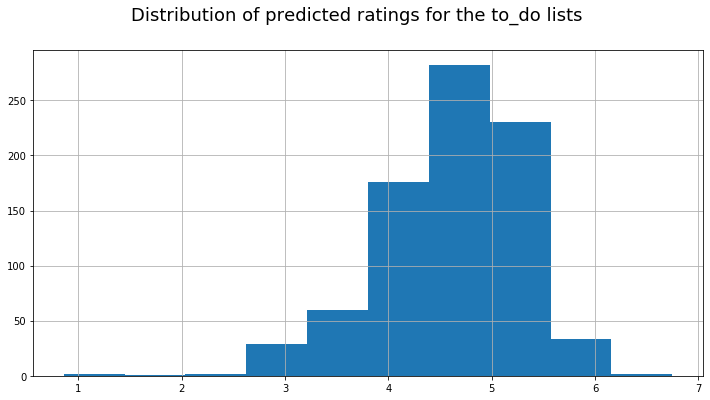

In [11]:
default_info = extracting_info_from_model(default_model)

In [ ]:
als_v2 = ALS(maxIter=10,regParam=0.05,rank=100, userCol="user_id",itemCol="book_id", ratingCol="rating",coldStartStrategy="drop",nonnegative=True, implicitPrefs = False)

tuned_model_v1 = als_v2.fit(training)

default_info = extracting_info_from_model(tuned_model_v1)

In [ ]:
als_v3 = ALS(maxIter=20,regParam=0.15,rank=100, userCol="user_id",itemCol="book_id", ratingCol="rating",coldStartStrategy="drop",nonnegative=True, implicitPrefs = False)

tuned_model_v2 = als_v3.fit(training)

default_info = extracting_info_from_model(tuned_model_v2)